## C-M ratio implementation ##


In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle

# import our own small lib. I access this one through PyCharm
import nsidc

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


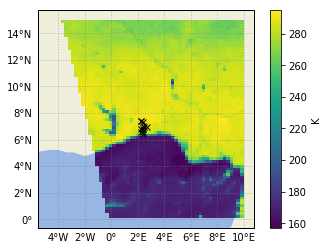

In [2]:
#2. OPEN THE DATASET AND DEFINE POINTS OF INTEREST

# ds = xr.open_dataset(fn_out)
# The following dataset satellite images of a certain region with specific settings (37GHz band, Horizontal Polarization, Ascending recording )
ds = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# get a mesh of the coordinates in grid's projection
xi, yi = np.meshgrid(ds.x, ds.y)

# the chosen projection is not (yet) supported by caropy.crs, so we need to do the transformation ourselves for now. 
# No biggy, here we go

# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)
# now drape the data on the map
p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())

# Ouémé delta 3 point calibration method - this is the current method that I'm testing.
# For now I'm only using it for 1 measurement cell, 
# but the idea in the end is that this will be used for the entire floodplain area. 
points_interest = [(2.43, 6.43),  #wet calibration - always covered in water (lake Nokoué)
                   
                   (2.25, 6.57),  #dry calibration 1 - never affected by "fluvial" inundations
                   (2.43, 6.55),  #measurement cell 1 - sometimes affected, real point of interest
                   
                   (2.25, 6.82),  #dry calibration 2
                   (2.43, 6.80),  #measurement cell 2
                   
                   (2.25, 7.40),  #dry calibration 3 (7.07 normally)
                   (2.43, 7.05),  #measurement cell 3
                   
                   (2.25, 7.40),  #dry calibration 4 (7.32 normally)
                   (2.43, 7.30),   #measurement cell 4
                   
                   (2.69936, 6.90851), #bonou dry calibration
                   (2.44936, 6.90851) #bonou measurement cell
                  ]
# # Ouémé gaging station Hounkpe and Badou (2007)
# points_interest = [(2.4406387000000223, 6.893251099999999),
#                    (2.2999999999999545, 7.099999999999999),
#                    (2.4851462999999967, 8.0335995),
#                    (2.0499999999999545, 7.566667)
# ]

# # Ouémé delta (QGIS defined grid)
# points_interest = [(2.28, 6.43),
#                    (2.38, 6.43),
#                    (2.48, 6.43),
#                    (2.58, 6.43),
#                    (2.28, 6.53),
#                    (2.38, 6.53),
#                    (2.48, 6.53),
#                    (2.58, 6.53),
#                    (2.28, 6.63),
#                    (2.38, 6.63),
#                    (2.48, 6.63),
#                    (2.58, 6.63),
#                    (2.28, 6.73),
#                    (2.38, 6.73),
#                    (2.48, 6.73),
#                    (2.58, 6.73),
#                    (2.28, 6.83),
#                    (2.38, 6.83),
#                    (2.48, 6.83),
#                    (2.58, 6.83),
#                    (2.44, 6.89)
# ]
                  
# #Niger (Hessel):
# points_interest = [(-6.565704345703125, 13.366907166629518),
#                    (-2.8667449951171875, 16.678293098288513),
# ]

#Some coding to visualise the area. 
ax = plt.axes(projection=ccrs.PlateCarree())
ax = nsidc.plot_points(ax, points_interest, marker='x', color='k', linewidth=0., transform=ccrs.PlateCarree())
plt.colorbar(p, label='K')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Gracefully close ds
ds.close()

We assume there is a dataset available to work with (downloaded with NSIDC_Measures.ipynb). I have downloaded several netcdf files, which can be used to:

- extract a time series of brightness temperatures over a river section
- extract time series in the surroundings of river section.
- apply the C/M ratio method (see Brakenridge et al., 2007, http://onlinelibrary.wiley.com/doi/10.1029/2006WR005238/full
- apply new test methods to support flood behaviour analysis.

We start by defining gauging points of interest, and transform these into the projection system of the Measures grids.

In [3]:
#3. COORDINATE SYSTEM PROJECTIONS
#Transforming the coordinate system. The data is available from a Measures dataset by NASA with a weird projection system
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'

# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)


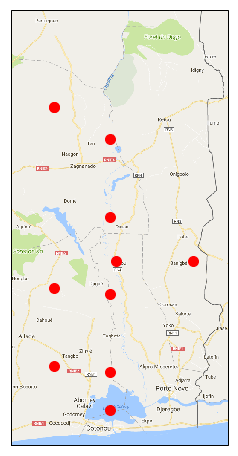

In [4]:
# 4.VISUALISE POINTS OF INTEREST
# first have a look at the points
osm_tiles = moa()
x, y = zip(*points_interest)

plt.figure(figsize=(8, 8))

# Use the tile's projection for the underlying map.
ax = plt.axes(projection=osm_tiles.crs)

# Specify a region of interest, in this case, Cardiff.
# ax.set_extent([1, 3, 6, 9],
#               ccrs.PlateCarree())

# Add the tiles at zoom level 10.
ax.add_image(osm_tiles, 10)
ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree())
# ax.coastlines('10m')

plt.show()
# fig.savefig(r'C:\Users\908138\githubdata\map_poi2.png')

In [5]:
#5. OPEN DATASET

# Uncheck for Wouter's files:
# os.path.abspath('../../githubdata/*.nc')
try:
    fns = glob.glob(r'C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
    fns_D = glob.glob(r'C:\\Users\\908138\\githubdata\\37ghz_25km_H_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-D_2010.nc')

except:
    print('No data file found, please put check the following location: {:s}')

## Uncheck for Hessel's files:
# fns = glob.glob(r'd:\git\satellite-cookbook\NSIDC-AMSRE\netcdf\*.nc')

#fns = [fns_1, fns_2]
#fns.sort()
print('Ascending node: ', fns) # 1:30 PM overpass, South to North #https://nsidc.org/data/modis/terra_aqua_differences
print('Descending node: ',fns_D) # 10:30 AM overpass, North to South

Ascending node:  ['C:\\\\Users\\\\908138\\\\githubdata\\\\37ghz_25km_H_A\\\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc']
Descending node:  ['C:\\\\Users\\\\908138\\\\githubdata\\\\37ghz_25km_H_D\\\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-D_2010.nc']


C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  import sys


Text(0,0.5,'Brightness Temperature (K)')

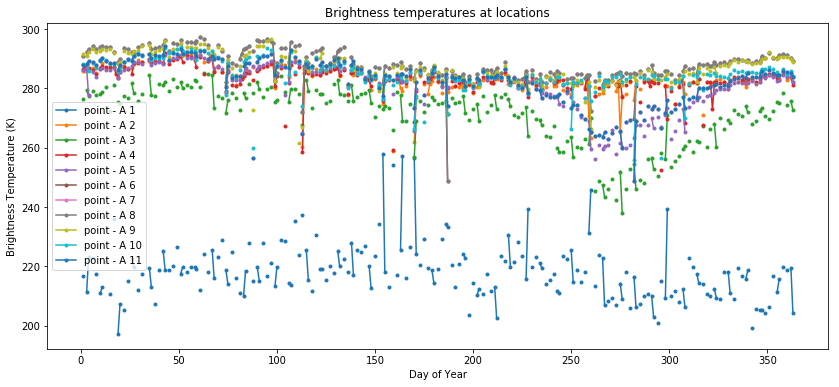

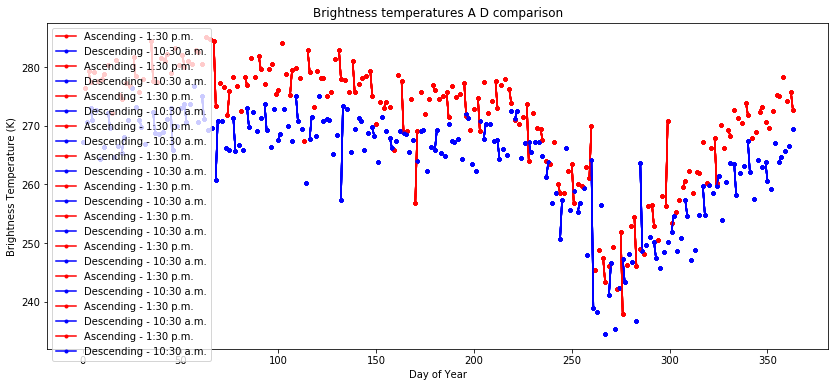

In [6]:
#6. PLOT TB (BRIGHTNESS TEMPERATURE)
ds = xr.open_mfdataset(fns[0:10])
ds_D = xr.open_mfdataset(fns_D[0:10])
points_x, points_y = zip(*points_xy)

ts = ds.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_D = ds_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')

# From variable 'TB' let's plot time series sequentially
plt.figure(figsize=(14,6))
values = ts['TB'].values
values_D = ts_D['TB'].values
for n in range(len(ts['TB'])):
    #ax = plt.subplot(int('31{}'.format(n+1)))
    #ts['TB'][n].plot(ax=ax, marker='.', linewidth=0., label='point {:d}'.format(n + 1))
    plt.plot(values[n], marker='.', label='point - A {:d}'.format(n + 1))
    #plt.plot(values_D[n], marker='.', label='point - D {:d}'.format(n+1))
plt.legend()
plt.title('Brightness temperatures at locations')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


# Plot and compare the ascending and descending orbits
plt.figure(figsize=(14,6))
values = ts['TB'].values
values_D = ts_D['TB'].values
for n in range(len(ts['TB'])):
    #ax = plt.subplot(int('31{}'.format(n+1)))
    #ts['TB'][n].plot(ax=ax, marker='.', linewidth=0., label='point {:d}'.format(n + 1))
    plt.plot(values[2], marker='.', color='red', label='Ascending - 1:30 p.m.')
    plt.plot(values_D[2], marker='.', color='blue', label='Descending - 10:30 a.m.')
plt.legend()
plt.title('Brightness temperatures A D comparison')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')



Text(0,0.5,'Percentage')

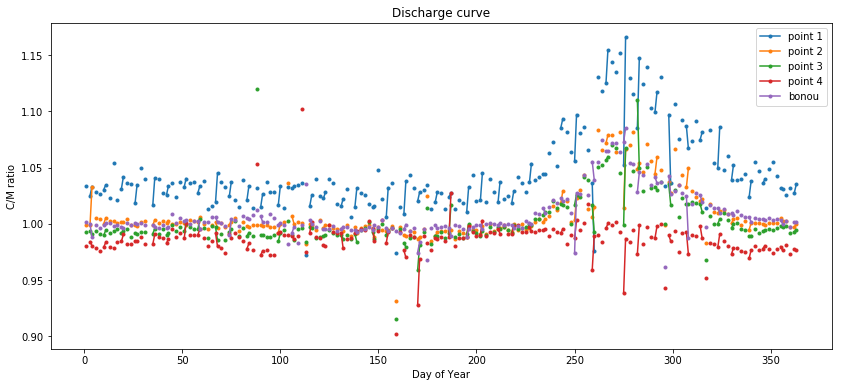

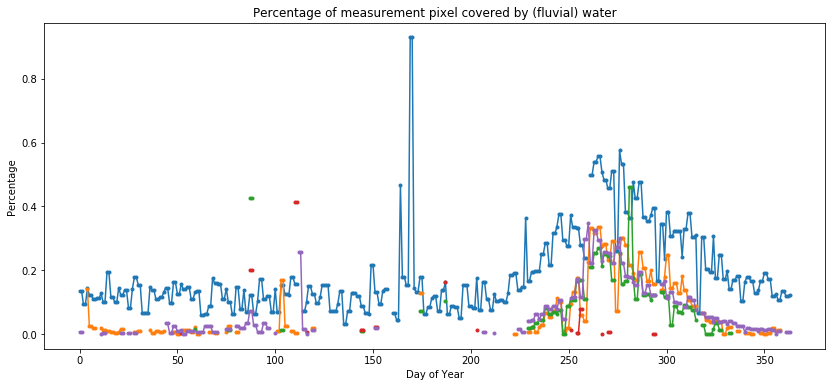

In [7]:
# 7. MODIFY THE TB TO PLOT C/M RATIO. THIS RATIO RESEMBLES THE BEHAVIOUR OF A RIVER DISCHARGE CURVE
# FURTHERMORE, WITH THE 3 POINT CALIBRATION, WE DETERMINE THE PERCENTAGE OF PIXEL COVERED BY WATER
# 

# Now let's plot the difference between the measurement cell (3) and the dry cell (2) 
# to generate a discharge like curve
q_wet = values[0] # wet calibration cell
q_d1 = values[1] #dry calibration cell 1
q_m1 = values[2] #measurement cell 1
q_d2 = values[3] 
q_m2 = values[4]
q_d3 = values[5] 
q_m3 = values[6]
q_d4 = values[7]
q_m4 = values[8]
q_dbon = values[9]
q_mbon = values[10]
# q_m5 = values[6]

# q_dbon

values_q1 = ((q_d1 / q_m1))
values_q2 = ((q_d1 / q_m2))
values_q3 = ((q_d1 / q_m3))
values_q4 = ((q_d1 / q_m4))
values_qbon = ((q_dbon / q_mbon))
# values_q5 = ((q_dry / q_m5))

plt.figure(figsize=(14,6))
plt.plot(values_q1, marker='.', label= 'point 1')
plt.plot(values_q2, marker='.', label= 'point 2')
plt.plot(values_q3, marker='.', label= 'point 3')
plt.plot(values_q4, marker='.', label= 'point 4')
plt.plot(values_qbon, marker='.', label= 'bonou')
# plt.plot(values_q5, marker='.', label= 'point 5')

plt.legend()

plt.title('Discharge curve')
plt.xlabel('Day of Year')
plt.ylabel('C/M ratio')

# Let's define the % coverered in water
# Preliminary assumption: wet cell = 100% water, dry cell = 0% water
p1 = ((q_d1 - q_m1)/ (q_d1 - q_wet)) #defining p as percentage of pixel covered. 
p2 = ((q_d1 - q_m2)/ (q_d1 - q_wet))
p3 = ((q_d1 - q_m3)/ (q_d1 - q_wet))
p4 = ((q_d1 - q_m4)/ (q_d1 - q_wet))
pbon = ((q_dbon - q_mbon)/ (q_dbon - q_wet))
# p5 = ((q_dry - q_m5)/ (q_dry - q_wet))
# plt.figure(figsize=(14,6))       
# plt.plot(p, marker = '.', label = 'percentage')    
# plt.title('Percentage of measurement pixel covered by (fluvial) water')
# plt.xlabel('Day of Year')
# plt.ylabel('Percentage')


# Fill the missing numbers (NaN) with a backward fill method
P1 = pd.DataFrame(p1)
P2 = pd.DataFrame(p2)
P3 = pd.DataFrame(p3)
P4 = pd.DataFrame(p4)
Pbon = pd.DataFrame(pbon)
# P5 = pd.DataFrame(p5)

# print(P)
P1.fillna(method='bfill',inplace=True)
P2.fillna(method='bfill',inplace=True)
P3.fillna(method='bfill',inplace=True)
P4.fillna(method='bfill',inplace=True)
Pbon.fillna(method='bfill',inplace=True)
# P5.fillna(method='bfill',inplace=True)

# print(P)
P1[P1<0] = P1.fillna(method='bfill',inplace=True)
P2[P2<0] = P2.fillna(method='bfill',inplace=True)
P3[P3<0] = P3.fillna(method='bfill',inplace=True)
P4[P4<0] = P4.fillna(method='bfill',inplace=True)
Pbon[Pbon<0] = Pbon.fillna(method='bfill',inplace=True)
# P5[P5<0] = P5.fillna(method='bfill',inplace=True)

# P[P<0] = 0
plt.figure(figsize=(14,6))       
plt.plot(P1, marker = '.', label = 'percentage')    
plt.plot(P2, marker = '.', label = 'percentage')    
plt.plot(P3, marker = '.', label = 'percentage')    
plt.plot(P4, marker = '.', label = 'percentage')
plt.plot(Pbon, marker = '.', label = 'percentage')
# plt.plot(P5, marker = '.', label = 'percentage')    

plt.title('Percentage of measurement pixel covered by (fluvial) water')
plt.xlabel('Day of Year')
plt.ylabel('Percentage')


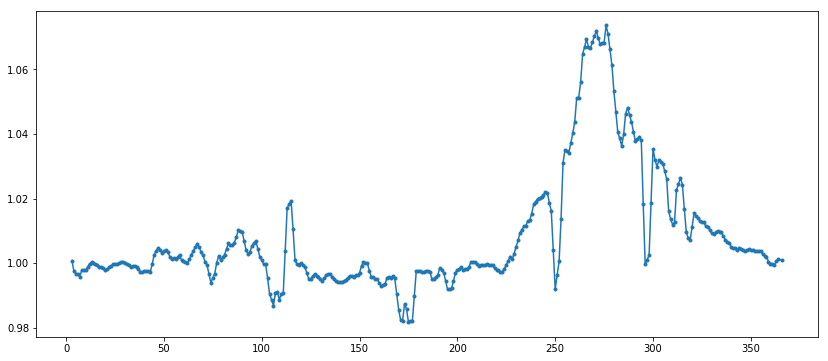

In [8]:
# CM RATIO

# # Now let's plot the difference between the measurement cell and the dry cell to generate a discharge like curve
q_dbon = values[9]
q_mbon = values[10]

cm_bon = (q_dbon/q_mbon)

CM_bon = pd.DataFrame(cm_bon) #Take out NaN entries
CM_bon.fillna(method='bfill',inplace=True) #Use same backward fill method as before
# #hastag beunen
CM_bon.iloc[[364]] = 1.0 #Manual edit the last entry. Has something to do with the fill method. Don't know why it has to happen here but not for the other two methods.
CM_bon.loc[366] = [1.0]  # adding a row to match the y and x axis later on (needs to be 366 x 1)

#Assign name to the column
# CM_bon.columns = ['Q']

#Moving average
# CM_bon = CM_bon['Q'].rolling(window=4,center=False).mean()
CM_bon = CM_bon.rolling(window=4,center=False).mean()


plt.figure(figsize=(14,6))
plt.plot(CM_bon, marker='.', label= 'bonou')


In [9]:
# CMC method with running average

# Pbon


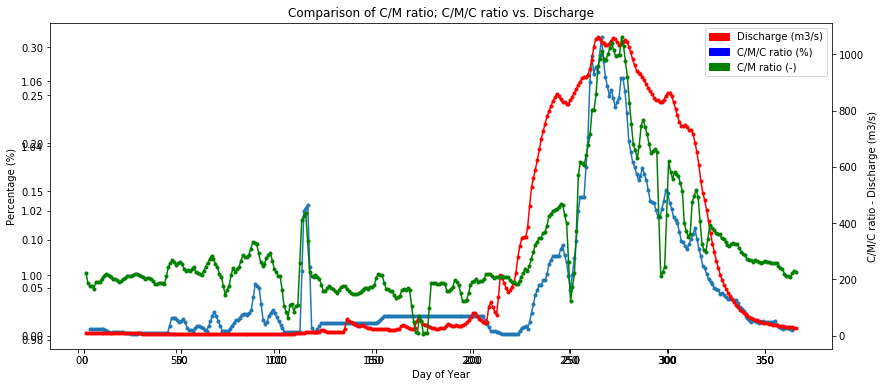

In [13]:
#8. PLOTTING AND COMPARISON - CMC METHOD VS. DISCHARGE
from pylab import figure, show, legend, ylabel, axes, pie, title
import matplotlib.patches as mpatches

# print(Pbon)

# CMC method with Running average
Pbon.columns = ['Q','Q_ma'] #How to fix this?
# Pbon.columns = ['Q']
Pbon['Q_ma'] = Pbon['Q'].rolling(window=4,center=False).mean()
Pbon[Pbon<0] = Pbon.fillna(method='ffill',inplace=True)

# Discharge data
path = (r"C:\\Users\\908138\\githubdata\\discharge\\bonou.csv")
df = pd.read_csv(path,skiprows=0,delimiter=';')
df.columns = ['doy','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959','1960','1961','1962','1963','1964','1965','1966','1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977','1978','1979','1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

q_2010 = df[['2010']]
doy = df[['doy']]

# Create the general figure
fig = plt.figure(figsize=(14,6))

# Plot satellite data
ax1 = fig.add_subplot(111)
plt.title('Comparison of C/M ratio; C/M/C ratio vs. Discharge')
plt.xlabel('Day of Year')
q_cmc = ax1.plot(Pbon['Q_ma'], marker='.', label = 'percentage')    
ylabel('Percentage (%)')

# Add discharge data in the same figure
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
q_dis = ax2.plot(doy,q_2010, linestyle='-', color='r',marker='.')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ylabel("C/M/C ratio - Discharge (m3/s)")

# Add C/M ratio in the same figure
# ax3 = fig.add_subplot(111, sharex=ax1, frameon = False)
# # plt.plot(CM_bon, marker='.', label= 'C/M ratio')
ax3 = fig.add_subplot(111, frameon = False)
q_cm = ax3.plot(doy,CM_bon, linestyle='-', color='g',marker='.')
ax3.yaxis.tick_left()
ax3.yaxis.set_label_position("left")

# #set y-axis to new position
# pos1 = ax3.get_position #original position
# print(pos1)
# # pos2 = [pos1.y0 - 0.5]
# # ax3.set_position(pos2)
# ylabel("C/M ratio")

# Very professional things done here
red_patch = mpatches.Patch(color='red', label='Discharge (m3/s)')
blue_patch = mpatches.Patch(color='blue', label='C/M/C ratio (%)')
green_patch = mpatches.Patch(color='green', label='C/M ratio (-)')

plt.legend(handles=[red_patch,blue_patch,green_patch])
plt.show()
fig.savefig(r'C:\Users\908138\githubdata\graph_3m.png')


In [14]:
# TO DO
# 1. INSERT DEM
# 2. CLIP TO GIVEN AREA OF INTEREST (25X25KM BOX)
# 3. CONNECT PERCENTAGE OF WATER IN PIXEL TO LOWEST PIXELS IN DEM
# 4. VISUALISE IN DEM
# 5. OPTIMIZE THE ASSIGNING PIXELS PART


In [15]:
data = pd.DataFrame(dict(
    s1=[CM_bon], #CM Ratio
    s2=[Pbon['Q_ma']], #CMC ratio
    s3=[q_2010] #discharge
))

In [16]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_style'), '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax
    plt.plot()
    show()

# plots.plot_multi(data.cumsum(), figsize=(10, 5))
# #8. PLOTTING AND COMPARISON - CMC METHOD VS. DISCHARGE
# from pylab import figure, show, legend, ylabel
# import matplotlib.patches as mpatches



# # CMC method with Running average
# Pbon.columns = ['Q', 'Q_ma']
# Pbon['Q_ma'] = Pbon['Q'].rolling(window=4,center=False).mean()
# # Pbon[Pbon<0] = Pbon.fillna(method='ffill',inplace=True)

# # Discharge data
# path = (r"C:\\Users\\908138\\githubdata\\discharge\\bonou.csv")
# df = pd.read_csv(path,skiprows=0,delimiter=';')
# df.columns = ['doy','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959','1960','1961','1962','1963','1964','1965','1966','1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977','1978','1979','1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

# q_2010 = df[['2010']]
# doy = df[['doy']]

# # Create the general figure
# fig = plt.figure(figsize=(14,6))

# # Plot satellite data
# ax1 = fig.add_subplot(111)
# plt.title('C/M/C ratio vs. Discharge data')
# plt.xlabel('Day of Year')
# q_cmc = ax1.plot(Pbon['Q_ma'], marker='.', label = 'percentage')    
# ylabel('Percentage (%)')

# # Add discharge data in the same figure
# ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
# q_dis = ax2.plot(doy,q_2010, linestyle='-', color='r',marker='.')
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
# ylabel("C/M/C ratio - Discharge (m3/s)")

# # Add C/M ratio in the same figure
# ax3 = fig.add_subplot(111, sharex=ax1, frameon = False)
# # # plt.plot(CM_bon, marker='.', label= 'C/M ratio')
# q_cm = ax3.plot(doy,CM_bon, linestyle='-', color='g',marker='.')
# # ax3.yaxis.tick_left()
# # ax3.yaxis.set_label_position("left")
# # ylabel("C/M ratio")

# # Very professional things done here
# red_patch = mpatches.Patch(color='red', label='Discharge (m3/s)')
# blue_patch = mpatches.Patch(color='blue', label='C/M/C ratio (%)')

# plt.legend(handles=[red_patch,blue_patch])
# plt.show()


Prepare for the selected points of interest a time series. We will save these in a list of time series 's'. After that we interactively plot the data. You can select which point you are looking at, which date, which time window around that date. Alongside the plotted date, you will see (right-hand side) a plot of the brightness temperatures over the point of interest. To-Do: make the spatial window around the point displayed also configurable.

In [17]:
#9. INTERACTIVE PLOTTING, USED TO PERFORM DAILY ANALYSIS.
#   PREFERABLY WE KEEP AS MUCH AS POSSIBLE FUNCTIONALITY IN THIS DAILY SYSTEM. 

s = [nsidc.c_m_ratio(ds['TB'], x, y)[2] for x, y in zip(points_x, points_y)]
#     s = [c_m_ratio(ds_win['TB'], x, y)[2] for ds_win, x, y in zip(window_ts, points_x, points_y)]
#ts = ds.sel_points(x=list(points_x), y=list(points_y), method='nearest')
#values = ts['TB'].values
px = list(points_x)
py = list(points_y)

def plot_func(idx, point, t_window, vmin, vmax):
    t = s[point].time.values[int(idx)]
    f = plt.figure(figsize=(20,10))
    ax1 = f.add_subplot(321)
    s[point].sel(time=slice(t- np.timedelta64(t_window, 'D'), t + np.timedelta64(t_window, 'D'))).plot(marker='.', linewidth=0.)
    plt.plot([t, t], ax1.get_ylim(), 'r')
    
    ax2 = f.add_subplot(322, projection=ccrs.PlateCarree())

    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.OCEAN)
    # get a mesh of the coordinates in grid's projection

    # now drape the data on the map
    p = ax2.pcolormesh(loni, lati, ds.sel(time=t)['TB'], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    # plot the current location in lat-lon
    p2 = plt.plot(*nsidc.proj_coord((s[point].x, s[point].y), proj_in, proj_out), marker='x', color='r')
    p3 = plt.plot(*nsidc.proj_coord((points_x[point], points_y[point]), proj_in, proj_out), marker='x', color='b')
    print(float(s[point].x), float(s[point].y))
    print(points_x[point], points_y[point])
    # also plot some points of interest 
    plt.colorbar(p, label='K')
    gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    
    ax3 = f.add_subplot(323)
    ax3.plot(values[point], marker='.', label='point {:d}'.format(point + 1))
    ax3.legend()
    # f.savefig
    
    ax4 = f.add_subplot(324, projection=ccrs.PlateCarree())

    ax4.add_feature(cfeature.LAND)
    ax4.add_feature(cfeature.OCEAN)
    # get a mesh of the coordinates in grid's projection

    # now drape the data on the map
    p = ax4.pcolormesh(loni, lati, ds.sel(time=t)['TB'], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    # plot the current location in lat-lon
    p2 = plt.plot(*nsidc.proj_coord((s[point].x, s[point].y), proj_in, proj_out), marker='x', color='r')
    # also plot some points of interest
    plt.colorbar(p, label='K')
    gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER

#     ax5.f.add_subplot(325)
xi, yi = np.meshgrid(ds.x, ds.y)

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)

# below we interactively plot!
interact(plot_func,
         idx=(0., len(s[0]), 1.),
         point=range(len(s)),
         t_window=(10, 730, 1),
         vmin=(230, 290, 1),
         vmax=(250, 310, 1),
         continuous_update=False,
        )


interactive(children=(FloatSlider(value=182.0, description='idx', max=365.0, step=1.0), Dropdown(description='…

<function __main__.plot_func(idx, point, t_window, vmin, vmax)>

In [18]:
# 10. DISCHARGE


In [19]:
# 10. DEM VISUALISATION
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import folium
from shapely import geometry
import matplotlib.pyplot as plt
import elevation
import os

%matplotlib inline

dem_path = r'C:\Users\908138\githubdata\dem_gmted10\GMTED2010S10E000_075\10s000e_20101117_gmted_mea075.tif'
output = dem_path

#This is how the coordinates were used before. 
# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)
# now drape the data on the map
# p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())

bounds = [(-5., 0.),
          (10., 15.),
         ]

elevation.clip(bounds=bounds, output=output, product = 'SRTM3')


ValueError: not enough values to unpack (expected 4, got 2)

In [33]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from pygeotools.lib import iolib, warplib, geolib, timelib, malib

#Function to generate a 3-panel plot for input arrays
def plot3panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,1, sharex=True, sharey=True, figsize=(14,6))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(adjustable='box-forced', aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255)) 
    #Plot each array 
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)

dem_test = r'C:\Users\908138\githubdata\dem_gmted10\GMTED2010S10E000_075\10s000e_20101117_gmted_mea075.tif'
dem_fn_list = [dem_test]

ds_list = warplib.memwarp_multi_fn(dem_fn_list, extent='intersection', res='min', t_srs=dem_test)


Warping all inputs to the following:
Resolution: 0.0020833333333333333
Extent: None
Projection: '+proj=longlat +datum=WGS84 +no_defs '
Resampling alg: cubic

1 of 1: C:\Users\908138\githubdata\dem_gmted10\GMTED2010S10E000_075\10s000e_20101117_gmted_mea075.tif


In [20]:
ts['x']


<xarray.DataArray 'x' (points: 11)>
array([237739.97, 212714.71, 237739.97, 212714.71, 237739.97, 212714.71,
       237739.97, 212714.71, 237739.97, 262765.23, 237739.97])
Coordinates:
    y        (points) float64 8.133e+05 8.383e+05 8.383e+05 8.634e+05 ...
    x        (points) float64 2.377e+05 2.127e+05 2.377e+05 2.127e+05 ...
Dimensions without coordinates: points
Attributes:
    standard_name:          projection_x_coordinate
    coverage_content_type:  coordinate
    long_name:              x
    units:                  meters
    axis:                   X
    valid_range:            [-17367530.44  17367530.44]

In [ ]:
ts['y']

Prepare for the selected points of interest a time series. We will save these in a list of time series 's'. After that we interactively plot the data. You can select which point you are looking at, which date, which time window around that date. Alongside the plotted date, you will see (right-hand side) a plot of the brightness temperatures over the point of interest. To-Do: make the spatial window around the point displayed also configurable.

In [ ]:
points_x[0]

In [ ]:
ts['y'][0]

Test

In [ ]:
TB = ds.sel('TB')
TB.plot()

In [ ]:
ds #This is what the dataset looks like

In [16]:
y

(6.43, 6.57, 6.55)

In [54]:
y

(6.43, 6.57, 6.55)